## 第6章: 機械学習

### 50. データの入手・整形

In [1]:
import pandas as pd
from sklearn.model_selection import train_test_split

data = pd.read_csv("data/newsCorpora.csv", sep="\t", header=None)
data.columns = ["ID", "TITLE", "URL", "PUBLISHER", "CATEGORY", "STORY", "HOSTNAME", "TIMESTAMP"]

publishers = ["Reuters", "Huffington Post", "Businessweek", "Contactmusic.com", "Daily Mail"]
data = data[data["PUBLISHER"].isin(publishers)]

data = data.loc[:, ["CATEGORY", "TITLE"]]

data = data.sample(frac=1, random_state=42)

train, test_valid = train_test_split(data, test_size=0.2, random_state=1, stratify=data["CATEGORY"])
test, valid = train_test_split(test_valid, test_size=0.5, random_state=1, stratify=test_valid["CATEGORY"])

train.to_csv("data/train.txt", sep="\t", index=False)
test.to_csv("data/test.txt", sep="\t", index=False)
valid.to_csv("data/valid.txt", sep="\t", index=False)

print("train:")
print(train["CATEGORY"].value_counts())
print("\ntest:")
print(test["CATEGORY"].value_counts())
print("\nvalid:")
print(valid["CATEGORY"].value_counts())

train:
CATEGORY
b    4502
e    4223
t    1219
m     728
Name: count, dtype: int64

test:
CATEGORY
b    563
e    528
t    152
m     91
Name: count, dtype: int64

valid:
CATEGORY
b    562
e    528
t    153
m     91
Name: count, dtype: int64


### 51. 特徴量抽出

In [ ]:
import re
import nltk
from nltk.stem.porter import PorterStemmer
from nltk.corpus import stopwords
from sklearn.feature_extraction.text import TfidfVectorizer

nltk.download('stopwords')

def prosess(text):
    text = re.sub(r"\s-*?\s", " ", text)
    text = re.sub(r"-", " ", text)
    text = re.sub(r"[\"\'.,:;\(\)#\|\*\+\!\?#$%&/\]\[\{\}]", "", text)
    text = re.sub(r"[0-9]+", "0", text)
    text = text.lower()

    stemmer = PorterStemmer()
    text = " ".join([stemmer.stem(word) for word in text.split()])

    stop_words = set(stopwords.words("english"))
    text = " ".join([word for word in text.split() if word not in stop_words])

    return text

united_data = pd.concat([train, test, valid]).reset_index(drop=True)
united_data["TITLE"] = united_data["TITLE"].map(prosess)

vectorizer = TfidfVectorizer(min_df=0.001)
X = vectorizer.fit_transform(united_data["TITLE"])
X_df = pd.DataFrame(X.toarray(), columns=vectorizer.get_feature_names_out())
X_df = pd.concat([united_data["CATEGORY"], X_df], axis=1)

train_df = X_df.iloc[:len(train)]
test_df = X_df.iloc[len(train):len(train)+len(test)]
valid_df = X_df.iloc[len(train)+len(test):]

train_df.to_csv("data/train.feature.txt", sep="\t", index=False)
test_df.to_csv("data/test.feature.txt", sep="\t", index=False)
valid_df.to_csv("data/valid.feature.txt", sep="\t", index=False)

print(train_df.shape)


[nltk_data] Downloading package stopwords to /home/vscode/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


(10672, 1638)


### 52. 学習

In [3]:
from sklearn.linear_model import LogisticRegression

X_train = train_df.drop(columns="CATEGORY")
y_train = train_df["CATEGORY"]
X_test = test_df.drop(columns="CATEGORY")
y_test = test_df["CATEGORY"]
X_valid = valid_df.drop(columns="CATEGORY")
y_valid = valid_df["CATEGORY"]

lg = LogisticRegression(random_state=42)
lg.fit(X_train, y_train)

LogisticRegression(random_state=42)

### 53. 予測

In [4]:
pred = lg.predict_proba(X_test)
display(pred)

array([[0.0080967 , 0.97998667, 0.00445748, 0.00745914],
       [0.03260907, 0.01449254, 0.93636033, 0.01653806],
       [0.07542916, 0.82062206, 0.0244991 , 0.07944968],
       ...,
       [0.96249265, 0.01688951, 0.0066456 , 0.01397225],
       [0.14497298, 0.19366288, 0.14166536, 0.51969878],
       [0.91343417, 0.04241022, 0.01314624, 0.03100937]])

### 54. 正解率の計測

In [ ]:
from sklearn.metrics import accuracy_score
y_train_pred = lg.predict(X_train)
y_test_pred = lg.predict(X_test)
y_train = train_df['CATEGORY']
y_test = test_df['CATEGORY']
print(accuracy_score(y_train, y_train_pred))
print(accuracy_score(y_test, y_test_pred))

0.9248500749625187
0.896551724137931


### 55. 混同行列の作成

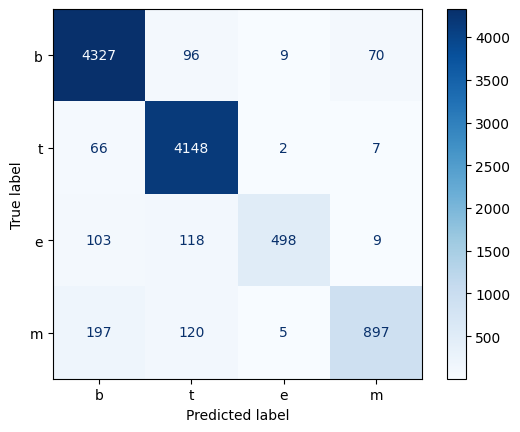

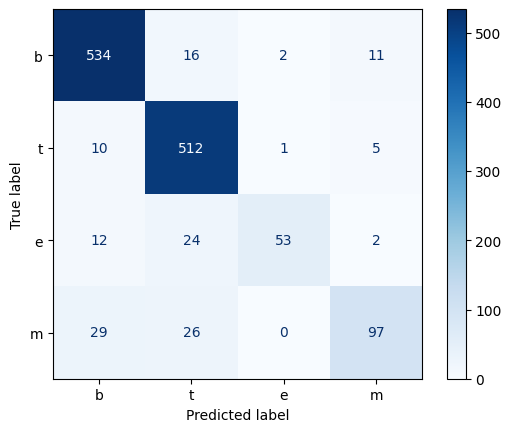

In [13]:
from matplotlib import pyplot as plt
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
    
# Confusion matrixの生成
cm_train = confusion_matrix(y_train, y_train_pred)
cm_test = confusion_matrix(y_test, y_test_pred)

# Confusion matrixの表示
disp = ConfusionMatrixDisplay(confusion_matrix=cm_train, display_labels=['b','t','e','m'])
disp.plot(cmap=plt.cm.Blues)
disp = ConfusionMatrixDisplay(confusion_matrix=cm_test, display_labels=['b','t','e','m'])
disp.plot(cmap=plt.cm.Blues)
plt.show()

### 56. 適合率, 再現率, F1スコアの計測

In [ ]:
from sklearn.metrics import precision_score, recall_score, f1_score
print(precision_score(y_test, y_test_pred, average=None, labels=['b','t','e','m']))
print(recall_score(y_test, y_test_pred, average=None, labels=['b','t','e','m']))
print(f1_score(y_test, y_test_pred, average=None, labels=['b','t','e','m']))
print(precision_score(y_test, y_test_pred, average='micro', labels=['b','t','e','m']))
print(recall_score(y_test, y_test_pred, average='micro', labels=['b','t','e','m']))
print(f1_score(y_test, y_test_pred, average='micro', labels=['b','t','e','m']))
print(precision_score(y_test, y_test_pred, average='macro', labels=['b','t','e','m']))
print(recall_score(y_test, y_test_pred, average='macro', labels=['b','t','e','m']))
print(f1_score(y_test, y_test_pred, average='macro', labels=['b','t','e','m']))

[0.91282051 0.84347826 0.88581315 0.94642857]
[0.94849023 0.63815789 0.96969697 0.58241758]
[0.93031359 0.72659176 0.92585895 0.72108844]
0.896551724137931
0.896551724137931
0.896551724137931
0.8971351234768941
0.784690669439314
0.825963183924839


### 57. 特徴量の重みの確認

In [21]:
import numpy as np
 
features = X_train.columns.values
for c, coef in zip(lg.classes_, lg.coef_):
  top_10 = pd.DataFrame(features[np.argsort(-coef)[:10]], columns=[f"重みの高い特徴量トップ10（クラス名：{c}）"], index=[i for i in range(1, 11)])
  worst_10 = pd.DataFrame(features[np.argsort(coef)[:10]], columns=[f"重みの低い特徴量トップ10（クラス名：{c}）"], index=[i for i in range(1, 11)])
  print( top_10, "\n"),
  print(worst_10, "\n", "-"*70)

   重みの高い特徴量トップ10（クラス名：b）
1                   bank
2                  stock
3                    fed
4                  china
5                    ecb
6                   euro
7                 ukrain
8                 dollar
9                    oil
10                profit 

   重みの低い特徴量トップ10（クラス名：b）
1                   star
2                  ebola
3               facebook
4                   live
5                  studi
6                   appl
7                   viru
8                   kill
9                  aereo
10                 video 
 ----------------------------------------------------------------------
   重みの高い特徴量トップ10（クラス名：e）
1             kardashian
2                   film
3                   chri
4                   star
5                   movi
6                   paul
7                    kim
8                    wed
9                   cyru
10                 miley 

   重みの低い特徴量トップ10（クラス名：e）
1                  updat
2                  googl
3                     u

### 58. 正規化パラメータの変更

【正則化パラメータ：0.001】

train_accuracy：0.46383058470764615
valid_accuracy：0.46476761619190404
test_accuracy：0.4662668665667166

【正則化パラメータ：0.025750000000000002】

train_accuracy：0.7766116941529235
valid_accuracy：0.7691154422788605
test_accuracy：0.7743628185907047

【正則化パラメータ：0.0505】

train_accuracy：0.7845764617691154
valid_accuracy：0.7796101949025487
test_accuracy：0.7811094452773614

【正則化パラメータ：0.07525000000000001】

train_accuracy：0.8013493253373314
valid_accuracy：0.7998500749625187
test_accuracy：0.7938530734632684

【正則化パラメータ：0.1】

train_accuracy：0.8193403298350824
valid_accuracy：0.8215892053973014
test_accuracy：0.8163418290854573



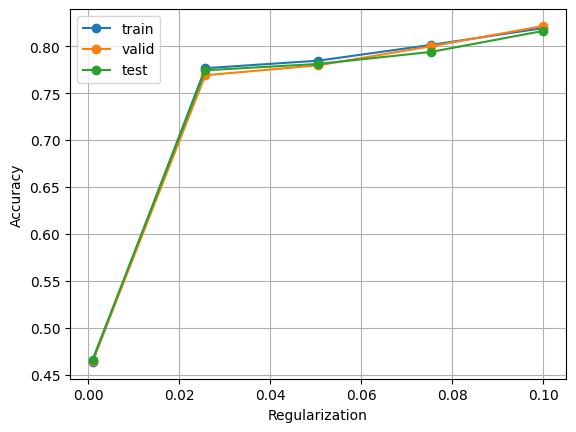

In [24]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score
import matplotlib.pyplot as plt

#モデル構築、学習（関数）
def LR_model_fit(x_data, y_data, c):
  lg = LogisticRegression(random_state=42, C=c)
  lg.fit(X_train, y_train)
  return lg

#学習済みモデルを用いて予測する（関数）
def LR_pred(x_data, y_data, model):
  Y_pred_data = model.predict(x_data)
  accuracy = accuracy_score(Y_pred_data, y_data)
  return accuracy

train_acc = []
valid_acc = []
test_acc = []

#正則化パラメータ
c_list = np.linspace(0.001, 0.1, 5)

for c in c_list:
  model = LR_model_fit(X_train, y_train, c)
  pre_train = LR_pred(X_train, y_train, model)
  pre_valid = LR_pred(X_valid, y_valid, model)
  pre_test = LR_pred(X_test, y_test, model)

  train_acc.append(pre_train)
  valid_acc.append(pre_valid)
  test_acc.append(pre_test)

  print(f"【正則化パラメータ：{c}】\n")
  print(f"train_accuracy：{pre_train}")
  print(f"valid_accuracy：{pre_valid}")
  print(f"test_accuracy：{pre_test}\n")

#可視化
plt.plot(c_list, train_acc, label="train", marker="o")
plt.plot(c_list, valid_acc, label="valid", marker="o")
plt.plot(c_list, test_acc, label="test", marker="o")

plt.legend()
plt.grid(True)
plt.xlabel("Regularization")
plt.ylabel("Accuracy")
plt.show()

### 59. ハイパーパラメータの探索

In [27]:
from sklearn.model_selection import GridSearchCV

params = {"C": [0.001, 0.005, 10]}

gs_model = GridSearchCV(LogisticRegression(max_iter=1500),params, cv=5, verbose=1)
gs_model.fit(X_train, y_train)

best_gs_model = gs_model.best_estimator_
print("\ntrain_score: {:.2%}".format(best_gs_model.score(X_train, y_train)))
print("valid_score: {:.2%}".format(best_gs_model.score(X_valid, y_valid)))
print("test_score: {:.2%}".format(best_gs_model.score(X_test, y_test)))

Fitting 5 folds for each of 3 candidates, totalling 15 fits

train_score: 96.74%
valid_score: 89.81%
test_score: 89.36%
